In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300


In [2]:
act = np.stack([np.load('../activationsData/{i}.npy') for i in range(9)])
act.shape


(100, 48, 1600)

In [3]:
def compute_conceptor(X, aperture, svd=False, svd_eps=0.001):
    """
    Computes the conceptor matrix for a given input matrix X and an aperture value.

    Parameters:
    - X (numpy.ndarray): Input matrix of shape (n_samples, n_features).
    - aperture (float): Aperture value used to compute the conceptor matrix.
    - svd (bool): if true compute conceptor using singular value decomposition
    Returns:
    - numpy.ndarray: Conceptor matrix of shape (n_features, n_features).
    """
    R = np.dot(X.T, X) / X.shape[0]
    if not svd:
        C = np.dot(R, np.linalg.inv(R + aperture ** (-2) * np.eye(R.shape[0])))
        return C
    else:
        U, S, _ = np.linalg.svd(R, full_matrices=False, hermitian=True)
        C = U*(S/(S+svd_eps*np.ones(S.shape)))@U.T
        return C


In [4]:
def rescale_aperture(C, prev_aperture, new_aperture):
    """Rescale the aperture of the given conceptor matrix.
    
    Parameters:
    - C (numpy.ndarray): Conceptor matrix of shape (n_features, n_features).
    - prev_aperture (float): Previous aperture value used to compute C.
    - new_aperture (float): New aperture value to rescale C.
    Returns:
    - numpy.ndarray: Rescaled conceptor matrix of shape (n_features, n_features).
    """
    scaling = prev_aperture/new_aperture
    return C @ np.linalg.inv(C + scaling**2 * (np.eye(C.shape[0]) - C))


## brief analysis

In [5]:
a = act[:, 0, :]
apertures = [1e-2, 1e-1, 1, 10, 50, 100] # invalid for 500, 1000?
Cs = [compute_conceptor(a, aper) for aper in apertures]
Ss = [np.linalg.svd(C, full_matrices=False, hermitian=True)[1] for C in Cs]


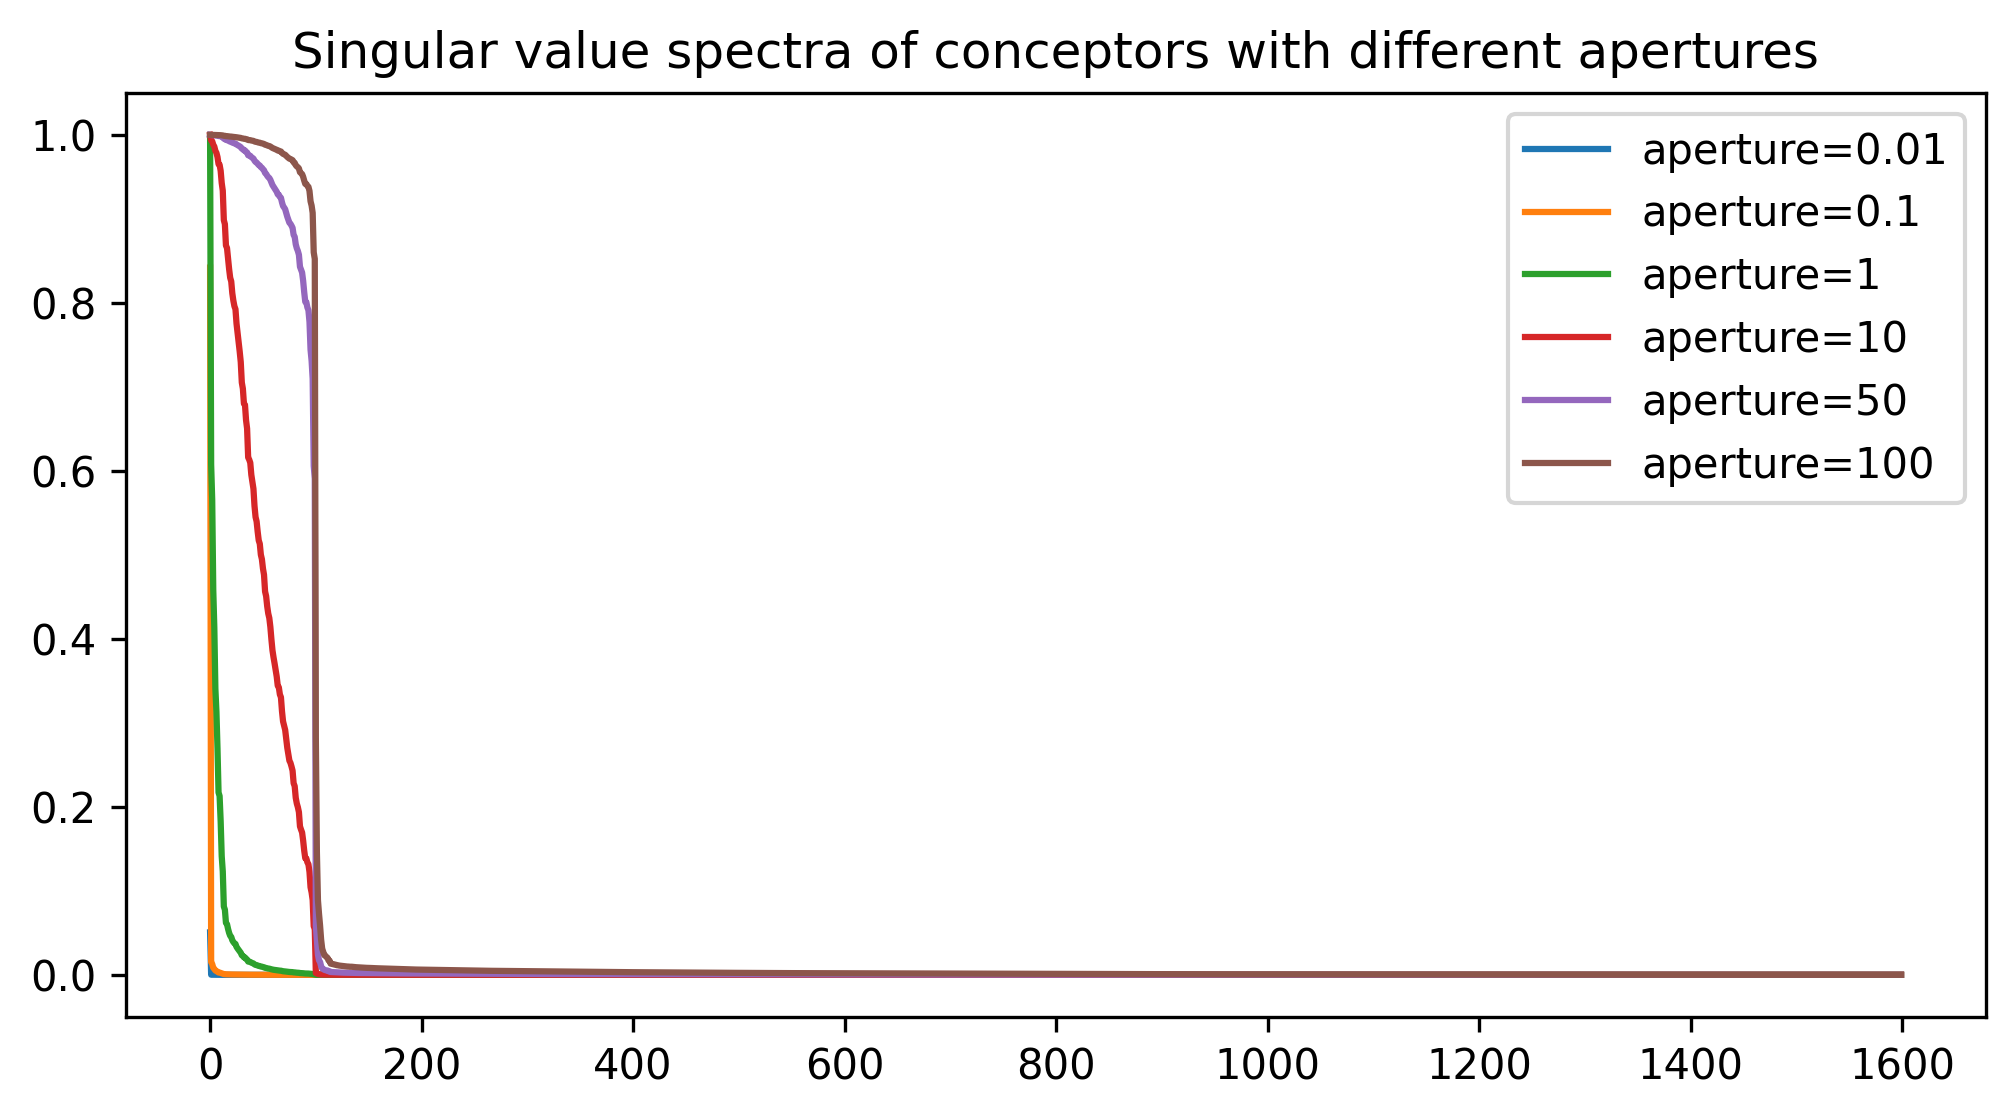

In [6]:
plt.figure(figsize=(8, 4), dpi=300)
plt.title('Singular value spectra of conceptors with different apertures')
for i, aper in enumerate(apertures):
    plt.plot(Ss[i], label=f'aperture={aper}')
plt.legend();


In [7]:
Cs = [rescale_aperture(Cs[3], 10, ap) for ap in apertures]
Ss = [np.linalg.svd(C, full_matrices=False, hermitian=True)[1] for C in Cs]


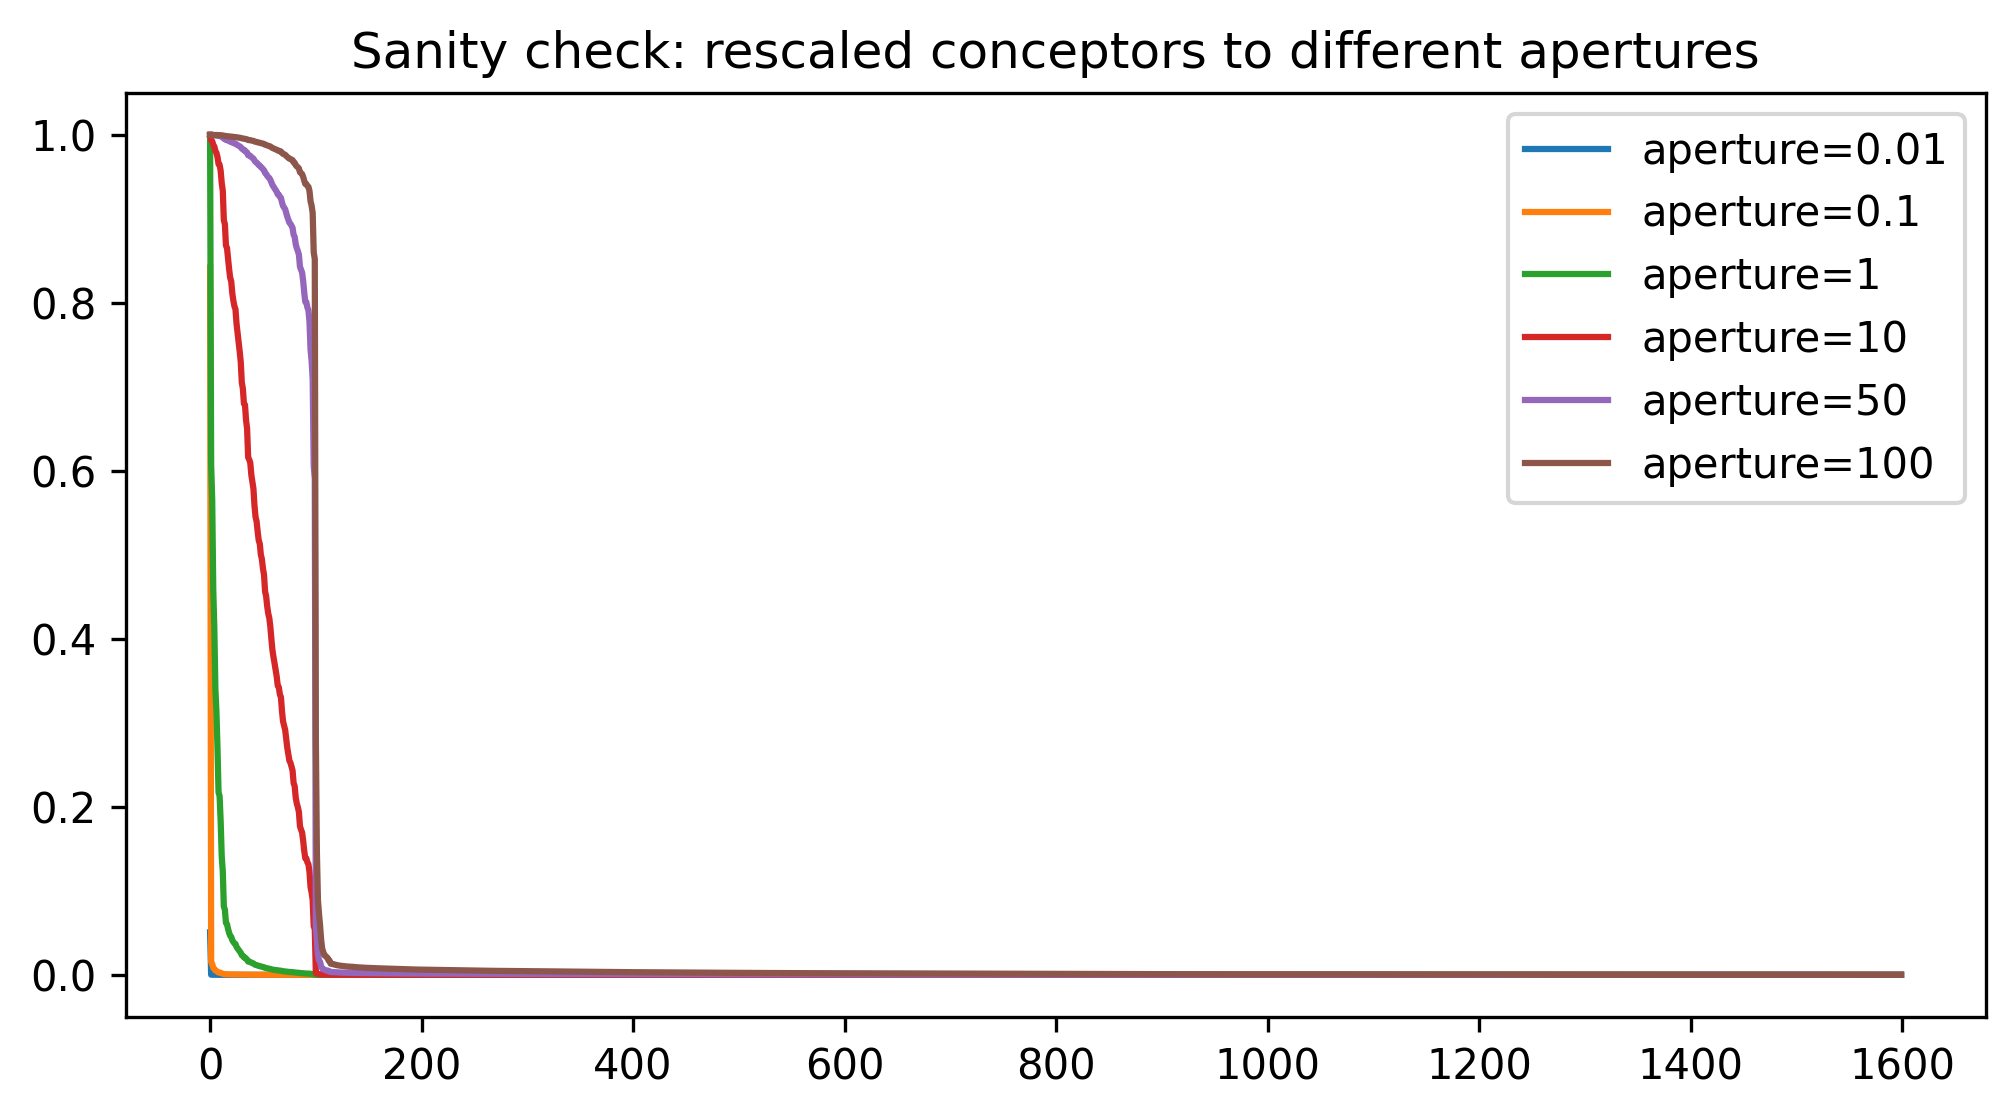

In [8]:
plt.figure(figsize=(8, 4), dpi=300)
plt.title('Sanity check: rescaled conceptors to different apertures')
for i, aper in enumerate(apertures):
    plt.plot(Ss[i], label=f'aperture={aper}')
plt.legend();


## compute and store conceptors for all activations

choosing an aperture value of 50 for now (can be rescaled later)

In [9]:
conceptors = np.zeros((act.shape[1], act.shape[2], act.shape[2]))
for layer_idx in range(act.shape[1]):
    conceptors[layer_idx] = compute_conceptor(act[:, layer_idx, :], aperture=50)


In [ ]:
np.save('conceptors.npy', conceptors)
with open('conceptors.txt', 'w') as f:
    f.write('Conceptors computed for each layer with aperture=50 -> shape '
            '(n_layers, n_features, n_features)')


## pseudocode for plugging it in

should be as easy as 
```python
C = np.load(...)  # (n_layers, n_features, n_features)
for layer in tranformer_net:
    x = layer(x)
    x = C_idx @ x  # simple dot product of conceptor (at layer idx) with layer activations
```